In [1]:
from processing.utils import *
from processing.utils2 import *
from processing.utils3 import *
from processing.gpcrdb_soup import *
from processing.download import *
from processing.processor import *
from processing.df_to_cif import *
from processing.bondtypes import *
from processing.affinities import *
from analysis.analysis import *
from neuralnet.delta_net import *
from neuralnet.egnn_sparse import *
from neuralnet.net_utils import *
from neuralnet.h5_net import *


from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from scipy.spatial.distance import cdist, pdist
from tqdm import trange

In [2]:
# Filtering etc is done with the processor!

In [3]:
p = CifProcessor()

In [4]:
p.read_pkl_metainfo()

In [5]:
p.table

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function
0,STE2,STE2,D1(Ste2-likefungalpheromone),strainATCC204508/S288c,cryo-EM,7AD3,3.5,A,Active,-,GPa1family,αPa1,Agonist
1,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,cryo-EM,6G79,3.8,S,Active,100,Gi/o,αo,Agonist
2,CCR2,Chemokine,A(Rhodopsin),Human,X-ray,5T1A,2.8,A,Inactive,31,-,-,AllostericantagonistAntagonist
3,OPRM,Opioid,A(Rhodopsin),Mouse,X-ray,4DKL,2.8,A,Inactive,7,-,-,Antagonist
4,CALRL,Calcitonin,B1(Secretin),Human,cryo-EM,7KNT,3.2,R,Inactive,10,-,-,Apo(noligand)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,PE2R4,Prostanoid,A(Rhodopsin),Human,cryo-EM,7D7M,3.3,A,Active,100,Gs,αs,Agonist
541,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,X-ray,5V54,3.9,A,Inactive,24,-,-,Antagonist
542,NTR1,Neurotensin,A(Rhodopsin),Rat,cryo-EM,7L0S,4.5,C,Active,100,Gi/o,αi1,Agonist
543,AA2AR,Adenosine,A(Rhodopsin),Human,X-ray,6S0Q,2.7,A,Inactive,0,-,-,Antagonist


In [6]:
p.read_pkl(mode='r', folder='data/processed/')

  0%|                                                                                                                                                                                                             | 0/545 [00:00<?, ?it/s]

Reading files with generic numbers on receptors.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 545/545 [01:51<00:00,  4.87it/s]


In [7]:
p.dfl[0]

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,phi,omega,psi,identifier,label_comp_sid
0,1F88,ATOM,A,A,1,1,MET,1,N,N,43.958,-5.980,-27.758,NaN,-179.718577,133.146625,OPSD_BOVIN,M
1,1F88,ATOM,A,A,1,1,MET,2,CA,C,44.718,-5.054,-26.911,NaN,-179.718577,133.146625,OPSD_BOVIN,M
2,1F88,ATOM,A,A,1,1,MET,3,C,C,44.069,-4.848,-25.543,NaN,-179.718577,133.146625,OPSD_BOVIN,M
3,1F88,ATOM,A,A,1,1,MET,4,O,O,42.854,-4.618,-25.451,NaN,-179.718577,133.146625,OPSD_BOVIN,M
4,1F88,ATOM,A,A,1,1,MET,5,CB,C,44.868,-3.699,-27.610,NaN,-179.718577,133.146625,OPSD_BOVIN,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062,1F88,ATOM,B,B,326,326,ASN,5063,O,O,33.779,28.612,-8.893,-55.581159,NaN,NaN,OPSD_BOVIN,N
5063,1F88,ATOM,B,B,326,326,ASN,5064,CB,C,31.698,31.250,-9.128,-55.581159,NaN,NaN,OPSD_BOVIN,N
5064,1F88,ATOM,B,B,326,326,ASN,5065,CG,C,31.032,32.204,-8.133,-55.581159,NaN,NaN,OPSD_BOVIN,N
5065,1F88,ATOM,B,B,326,326,ASN,5066,OD1,O,30.599,31.795,-7.049,-55.581159,NaN,NaN,OPSD_BOVIN,N


In [8]:
BOND_TYPE_DF

,H,N,C,O,S
H,0,1,2,3,4
N,1,5,6,7,8
C,2,6,9,10,11
O,3,7,10,12,13
S,4,8,11,13,14


In [9]:
FULL_ATOM_LIST = list(p.dfl[0]['label_atom_id'].unique())

In [10]:
class GraphProcessor(Dataset):
    def __init__(self,
                 d: list,
                 p: CifProcessor,
                 label_type = 'Log(Emax/EC50)'):
        self.d = d
        self.p = p
        self.allow_exception=False
        
        self.simplified = False
        if 'generic_position' in list(p.dfl[0].columns):
            self.simplified=True
        
        self.atom_list = FULL_ATOM_LIST
        self.edge_criteria = ['self', 'distance']
        self.edge_features = ['unitary', 'distance', 'EM']
        self.node_criteria = ['H5']
        
        self.assign_labels(label_type=label_type)
    
    # ================================================================================================================
    
    def simplify(self):
        if not self.simplified:
            for i in trange(len(self.p.dfl)):
                if self.allow_exception:
                    try:
                        df = self.p.dfl[i]
                        self.p.dfl[i] = pd.DataFrame()
                        self.p.dfl[i] = self._simplify_gen_pos(df).reset_index()
                    except:
                        pass
                else:
                    df = self.p.dfl[i]
                    self.p.dfl[i] = pd.DataFrame()
                    self.p.dfl[i] = self._simplify_gen_pos(df).reset_index()
                self.simplified = True
        else:
            pass
        
    def _simplify_gen_pos(self, df):
        def sgp(gen_pos='', gprot_pos=''):
            if gprot_pos != '':
                return gprot_pos
            else:
                return gen_pos.split('x')[0]
        cols = list(df.columns)
        if ('gen_pos' in cols) and ('gprot_pos' in cols):
            df['generic_position'] = df.apply(lambda x: sgp(x.gen_pos, x.gprot_pos), axis=1)
            df.drop(['group_PDB', 'label_seq_id', 'label_asym_id',
                    'auth_seq_id', 'id',
                    'phi', 'omega', 'psi', 'label_comp_id',
                    'label_2_uni', 'gen_pos', 'gen_pos1', 'gen_pos2', 'gprot_pos',
                    'uniprot_comp_id', 'fam_comp_id', 'uniprot_comp_sid'], axis=1, inplace=True)
            return df
        elif 'gen_pos' in cols:
            df['generic_position'] = df.apply(lambda x: sgp(x.gen_pos), axis=1)
            df.drop(['group_PDB', 'label_seq_id','label_asym_id',
                   'auth_seq_id', 'id',
                   'phi', 'omega', 'psi','label_comp_id',
                   'label_2_uni', 'gen_pos', 'gen_pos1', 'gen_pos2',
                   'uniprot_comp_sid'], axis=1, inplace=True)
            return df
        else:
            df['generic_position'] = ''
            df.drop(['group_PDB', 'label_seq_id','label_asym_id',
                   'auth_seq_id', 'id','label_comp_id',
                   'phi', 'omega', 'psi'], axis=1, inplace=True)   
            return df
        
    # ================================================================================================================
    
    def assign_labels(self, label_type = 'Log(Emax/EC50)'):
        A = AffinityProcessor(setting='families')
        A.set_label_type(label_type)
        A.set_group()
        prev_len = len(self.p.table)
        print("Filtering out samples with no associated affinity value...")
        self.p = filter_valid_pdbs_with_affinities(self.p, A)
        print("Retaining {} / {} samples!".format(len(self.p.table), prev_len))
        label_df = make_label_df(self.p, A, label_type)
        self.p.table = pd.merge(self.p.table, label_df, on='PDB')
    
    # ================================================================================================================
    
    def set_atom_list(self, filtered_atom_list=['CA']):
        self.atom_list = filtered_atom_list
        print("Set atom_list to {}.".format(self.atom_list))
    
    def apply_atom_list_filter(self):
        for i in range(len(self.p.dfl)):
            p.dfl[i] = p.dfl[i][p.dfl[i]['label_atom_id'].isin(self.atom_list)]
        print("Filtered p by atom_list.")
        
    # ================================================================================================================
    
    def create_graph(self, 
                     filter_by_chain=True,
                     gpcr=True,
                     gprotein=True,
                     auxilary=True,
                     node_criteria='H5', 
                     edge_criteria='radius',
                     h5start=13,
                     cons_r_res=['1.50', '3.50', '7.53'],
                     radius=12,
                     max_edge_dist=7):
        if node_criteria!=None:
            self.node_criteria = node_criteria
        self.selection = []
        self.edges = []
        self.edge_attrs = []
        self.d = []
        self.dl = []
        for i in trange(len(self.p.dfl)):
            # INITIALIZATION
            df = self.p.dfl[i]
            self._select_edge_criterion()
            self._select_edge_features()
            self._select_node_criterion()
            # NODE SELECTION
            df_idxs = self._get_selection(df,
                                          filter_by_chain=filter_by_chain,
                                          gpcr=gpcr,
                                          gprotein=gprotein,
                                          auxilary=auxilary,
                                          h5start=h5start,
                                          cons_r_res=cons_r_res,
                                          radius=radius)
            df_sele = self._filter_by_index_list(df, df_idxs)
            if len(df_sele) > 0:
                self.selection.append(df_sele)
                # EDGES: LIST
                edges = self._create_edge_list(df=df_sele, max_edge_dist=max_edge_dist)
                self.edges.append(edges)
                # EDGES: ATTRIBUTES
                edge_attr = self._get_edge_features(df_sele, edges, max_edge_dist)
                self.edge_attrs.append(edge_attr)
                y = self._get_label(df['PDB'].iloc[0])
                # Todo: get the node features (Z or atom-label (or both))
                x = df_sele.apply(lambda x: RES_DICT[x.label_comp_sid], axis=1).to_numpy().astype(np.int8)
                pos = df_sele[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
                self.d.append(self._get_data_object(x, edges, edge_attr, y, pos))
                self.dl.append(df['PDB'].iloc[0])
                print('\n\n\n')
            
            
    # ----------------------------------------------------------------------------------------------------------------
    
    def _select_edge_criterion(self, edge_criteria=[], edge_crit_dist=5):
        if not isinstance(edge_criteria, list):
            edge_criteria = [edge_criteria]
        if len(edge_criteria) > 0:
            self.edge_criteria = edge_criteria
        print("Selected edge criterion:", self.edge_criteria)
    
    def _select_edge_features(self, edge_features=[]):
        if not isinstance(edge_features, list):
            edge_features = [edge_features]
        if len(edge_features) > 0:
            self.edge_features = edge_features
        print("Selected edge features:", self.edge_features)
        
    def _select_node_criterion(self, node_criteria=[]):
        if not isinstance(node_criteria, list):
            node_criteria = [node_criteria]
        if len(node_criteria) > 0:
            self.node_criteria = node_criteria
        print("Selected criterion for node selection:", self.node_criteria)
              
    # ----------------------------------------------------------------------------------------------------------------
    
    def _get_selection(self, 
                       df: pd.DataFrame,
                       filter_by_chain,
                       gpcr,
                       gprotein,
                       auxilary,
                       h5start,
                       cons_r_res,
                       radius):
        # get a list of nodes (you can have multiple criterions met at the same time...)
        df.reset_index(inplace=True, drop=True)
        valid = []  # indices filtered by chain
        idxs = []  # list of selected nodes
        df_idxs = []  # list of selected nodes filtered by chain
        
        if filter_by_chain:
            print("Filtering by chain!")
            if gpcr:
                print("Adding gpcr to selection!")
                a = len(valid)
                valid += self._get_gpcr(df)
                print("Number valid gpcr atoms:", len(valid)-a)
            if gprotein:
                print("Adding gprotein to selection!")
                a = len(valid)
                valid += self._get_gprotein(df)
                print("Number valid gprotein atoms:", len(valid)-a)
            if auxilary:
                print("Adding auxilary chains to selection!")
                a = len(valid)
                valid += self._get_auxilary(df)
                print("Number valid auxilary atoms:", len(valid)-a)
        else:
            valid = list(df.index)
        valid = list(set(valid))
        print("In total using {} valid atoms!".format(len(valid)))
        
        if len(valid) >= 0:
            if 'H5' in self.node_criteria:
                print("Searching nodes meeting H5 criterion...")
                idxs += self._get_h5(df, h5start, radius)
            if 'Interaction Surface' in self.node_criteria:
                print("Searching nodes in the interaction surface...")
                idxs += self._get_interaction_surface(df)
            if 'Interaction Site' in self.node_criteria:
                print("Searching nodes in the interaction site...")
                idxs += self._get_interaction_site(df, cons_r_res=['1.50', '3.50', '7.53'], radius=radius)
            for idx in idxs:
                if idx in valid:
                    df_idxs.append(idx)
            return df_idxs
        else:
            print("No valid nodes found!")
            return []
    
    def _get_gpcr(self, df):
        # list(df.index)
        some_gen_pos = ['3.50', '6.50', '7.50']
        df_sgp = df[df['generic_position'].isin(some_gen_pos)]
        if len(df_sgp) > 0:
            gpcr_chain = df_sgp.iloc[0]['auth_asym_id']
            return list(df[df['auth_asym_id'].str.contains(gpcr_chain)].index)
        else:
            return []
    
    def _get_gprotein(self, df):
        # any chain with labels that mark it as a gprotein ~ i.e. generic residue number of said chain contains 'G.'
        df_gp = df[df['generic_position'].str.contains('G.')]
        if len(df_gp) > 0:
            gprot_chain = df_gp.iloc[0]['auth_asym_id']
            return list(df[df['auth_asym_id'].str.contains(gpcr_chain)].index)
        else:
            return []
        
    def _get_auxilary(self, df):
        # any chain with labels that mark it as a gprotein ~ i.e. generic residue number of said chain contains 'G.'
        chain_df = df.groupby('auth_asym_id')['generic_position'].nunique()
        chains = list(chain_df[chain_df==1].index)
        if len(chains) > 0:
            auxilary_df = df[df['auth_asym_id'].isin(chains)]
            return list(auxilary_df.index)
        else:
            return []
    
    def _get_h5(self, df, h5start, h5radius):
        # any chain with 
        print("Checking for nodes within H5 radius:", h5radius)
        strs = ['G.H5.' + str(x) for x in range(27) if ((x >= h5start) & (x <= 26))]
        df_h5 = df[df['generic_position'].isin(strs)]
        xyz_h5 = df_h5[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
        if len(xyz_h5) > 0:
            xyz_full = df[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            D = cdist(xyz_full, xyz_h5).T
            h5_list = []
            for p in range(D.shape[1]):
                if np.any(D[:, p] < h5radius):
                    h5_list.append(p)
            return h5_list
        else:
            return []
    
    def _get_interaction_surface(self, df, max_dist=7, n_neighbor_res=2):
        pass
    
    def _get_interaction_site(self, df, cons_r_res, radius):
        print("getting interaction site")
        int_site_corners = df[df['generic_position'].isin(cons_r_res)]
        if len(int_site_corners) == len(cons_r_res):
            xyz_corners = int_site_corners[['Cartn_x', 'Cartn_y', 'Cartn_z']].astype(float).to_numpy().mean(axis=1)
            xyz_full = df[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            D = cdist(xyz_full, xyz_corners[None,:]).T
            h5_list = []
            for p in range(D.shape[1]):
                if np.any(D[:, p] < radius):
                    h5_list.append(p)
            return h5_list
        else:
            return []
    
    def _filter_by_index_list(self, df, df_idxs):
        if len(df_idxs) > 0:
            filtered = df.loc[df.index[df_idxs]].reset_index(drop=True)
            return filtered
        else:
            return pd.DataFrame()
    
    # ----------------------------------------------------------------------------------------------------------------
    
    def _create_edge_list(self, 
                          df: pd.DataFrame,
                          max_edge_dist=7,
                          ):
        """
        Return a list of shape (2, number_of_edges)
        """
        edge_list = []
        if 'residual' in self.edge_criteria:
            # add connection between all atoms within the same residue
            pass
        if 'EM' in self.edge_criteria:
            pass
        if 'distance' in self.edge_criteria:
            xyz = df[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            D = cdist(xyz, xyz, 'euclidean')
            edge_dist_list = []
            for pi in range(D.shape[0]):
                if 'self' not in self.edge_criteria:
                    for pj in range(D.shape[1]):
                        D[i, i] = max_edge_dist + 1  # this removes all self interactions
                edges = np.where(D[:, pi] <= max_edge_dist)[0].tolist()
                for e in edges:
                    edge_dist_list.append((pi, e))
            edge_list += edge_dist_list
        elif 'self' in self.edge_criteria:
            # each node interacts with itself
            idxs = list(df.index)
            self_interactions = [(x, x) for x in idxs]
            edge_list += self_interactions
        return edge_list
        
        
    def _get_em_dist(self,
                     xyz1,
                     z1,
                     xyz2,
                     z2
                    ):
        em_dists = []
        # z1 * z2 / (dist^6)
        return em_dists
        
    # ----------------------------------------------------------------------------------------------------------------
        
    def _get_edge_features(self, df, edge_list, max_edge_dist):
        # unitary? --> 1 (for every edge)
        edge_features = []
        for _, (i, j) in enumerate(edge_list):
            features = []
            xyzi = df.iloc[i][['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            xyzj = df.iloc[j][['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            if 'unitary' in self.edge_features:
                features += [1]
            # distance? --> (euclidean distance)
            if 'distance' in self.edge_features:
                dist = np.linalg.norm(xyzi-xyzj)
                features += [dist / max_edge_dist]
            # EM?  --> z1 * z2 / r^6
            if 'em' in self.edge_features:
                # xyzi = df.iloc[i][]
                # xyzj = df.iloc[j][]
                features +=  [0]
            # atom-atom-interaction as a class (that we can embed)?
            if 'bond_embedding' in self.edge_features:
                features += [0]
            edge_features.append(features)
        return edge_features
              
    # ----------------------------------------------------------------------------------------------------------------

    def _get_label(self, pdb_id):
        return self.p.table[self.p.table['PDB']==pdb_id].iloc[0][['Gs','Gi/o','Gq/11','G12/13']]
              
    # ----------------------------------------------------------------------------------------------------------------
    
    def __getitem__(self, idx):
        return self.d[idx]
    
    def _get_data_object(self, x, edge_index, edge_attr, y, pos):
        """
        Input:
        data.x: Node feature matrix with shape [num_nodes, num_node_features]
        data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
        data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
        data.pos: Node position matrix with shape [num_nodes, num_dimensions]
        """
        x = torch.tensor(x, dtype=torch.long)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        pos = torch.tensor(pos, dtype=torch.float)
        return Data(x=x, edge_index=edge_index.T, edge_attr=edge_attr, y=y, pos=pos)
    
    
    def __getitem__(self, idx):
        return self.d[idx]
    
    def __len__(self):
        return len(self.d)
    
    # ================================================================================================================

In [11]:
# add gpcr/gprteotein as label

In [12]:
# del gp

In [13]:
gp = GraphProcessor(d=[], p=p)

Reading data from data/couplings/families_coupling.xls!


C:\Users\Flurin Hidber\Anaconda3\envs\mt\lib\site-packages\pandas\core\generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Initialized Affinity Processor!
Please set a group --------------  ['GPCRdb', 'Inoue', 'Bouvier'].
please set label type -----------  ['Guide to Pharmacology', 'Log(Emax/EC50)', 'pEC50', 'Emax'].

Selected label type 'Log(Emax/EC50)'.


Selected data of group 'GPCRdb'.

Filtering out samples with no associated affinity value...
Retaining 357 / 545 samples!


In [14]:
gp.p.table

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function,Gs,Gi/o,Gq/11,G12/13
0,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,cryo-EM,6G79,3.8,S,Active,100,Gi/o,αo,Agonist,0.0,8.9,6.7,0.0
1,CNR2,Cannabinoid,A(Rhodopsin),Human,X-ray,5ZTY,2.8,A,Inactive,6,-,-,Antagonist,0.0,8.9,0.0,0.0
2,CXCR2,Chemokine,A(Rhodopsin),Human,cryo-EM,6LFO,3.4,R,Active,100,Gi/o,αi1,Agonist,0.0,9.5,0.0,0.0
3,CXCR2,Chemokine,A(Rhodopsin),Human,cryo-EM,6LFM,3.5,R,Active,100,Gi/o,αi1,Agonist,0.0,9.5,0.0,0.0
4,CXCR2,Chemokine,A(Rhodopsin),Human,X-ray,6LFL,3.2,A,Inactive,7,-,-,Allostericantagonist,0.0,9.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,GNRHR,Gonadotrophin-releasinghormone,A(Rhodopsin),Human,X-ray,7BR3,2.8,A,Inactive,24,-,-,Antagonist,0.0,8.9,9.4,0.0
352,GLP1R,Glucagon,B1(Secretin),Human,cryo-EM,7LCK,3.2,R,Active,100,-,-,Agonist,10.6,0.0,0.0,0.0
353,PE2R4,Prostanoid,A(Rhodopsin),Human,cryo-EM,7D7M,3.3,A,Active,100,Gs,αs,Agonist,10.4,8.9,8.7,7.4
354,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,X-ray,5V54,3.9,A,Inactive,24,-,-,Antagonist,0.0,8.9,6.7,0.0


In [15]:
gp.p.dfl[0]

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,phi,omega,psi,identifier,label_comp_sid
0,2R4R,ATOM,A,A,37,37,GLY,1,N,N,12.352,38.788,28.880,NaN,179.541452,-103.545862,ADRB2_HUMAN,G
1,2R4R,ATOM,A,A,37,37,GLY,2,CA,C,11.554,38.126,29.950,NaN,179.541452,-103.545862,ADRB2_HUMAN,G
2,2R4R,ATOM,A,A,37,37,GLY,3,C,C,12.267,36.922,30.533,NaN,179.541452,-103.545862,ADRB2_HUMAN,G
3,2R4R,ATOM,A,A,37,37,GLY,4,O,O,13.195,37.070,31.329,NaN,179.541452,-103.545862,ADRB2_HUMAN,G
4,2R4R,ATOM,A,A,38,38,ILE,5,N,N,11.831,35.728,30.140,-60.266431,179.295701,-9.736188,ADRB2_HUMAN,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,2R4R,ATOM,H,C,217,217,CYS,4921,C,C,104.061,29.901,4.040,-63.407305,NaN,NaN,ADRB2_HUMAN,C
4921,2R4R,ATOM,H,C,217,217,CYS,4922,O,O,105.059,30.517,3.612,-63.407305,NaN,NaN,ADRB2_HUMAN,C
4922,2R4R,ATOM,H,C,217,217,CYS,4923,CB,C,101.677,29.803,3.295,-63.407305,NaN,NaN,ADRB2_HUMAN,C
4923,2R4R,ATOM,H,C,217,217,CYS,4924,SG,S,101.375,31.524,2.779,-63.407305,NaN,NaN,ADRB2_HUMAN,C


In [16]:
gp.set_atom_list()
gp.apply_atom_list_filter()

Set atom_list to ['CA'].
Filtered p by atom_list.


In [17]:
gp.simplify()

  0%|                                                                                                                                                                                                             | 0/356 [00:00<?, ?it/s]C:\Users\Flurin Hidber\Anaconda3\envs\mt\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Flurin Hidber\Anaconda3\envs\mt\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
100%|██████████████████

In [264]:
gp.create_graph(filter_by_chain=True,
                gpcr=True,
                gprotein=False,
                auxilary=False,
                node_criteria='Interaction Site', 
                edge_criteria='radius',
                h5start=13,
                cons_r_res=['3.50', '6.33'], 
                radius=12,
                max_edge_dist=7)

  4%|████████▊                                                                                                                                                                                          | 16/356 [00:00<00:02, 133.83it/s]

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 309
In total using 309 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge c

 12%|███████████████████████                                                                                                                                                                             | 42/356 [00:00<00:05, 56.77it/s]

 ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance

 15%|██████████████████████████████▎                                                                                                                                                                     | 55/356 [00:01<00:09, 33.09it/s]

 ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance

 26%|██████████████████████████████████████████████████                                                                                                                                                  | 91/356 [00:01<00:03, 79.08it/s]


Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge crit

 35%|█████████████████████████████████████████████████████████████████████                                                                                                                              | 126/356 [00:01<00:02, 96.07it/s]

Number valid gpcr atoms: 266
In total using 266 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number vali

 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 139/356 [00:02<00:03, 59.72it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 441
In total using 441 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selecte

 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 164/356 [00:02<00:02, 71.63it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 281
In total using 281 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 378
In total using 378 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Sel

 49%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 174/356 [00:03<00:03, 47.34it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 304
In total using 304 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected ed

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 182/356 [00:03<00:03, 47.16it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 264
In total using 264 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 196/356 [00:04<00:04, 34.85it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge c

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 205/356 [00:04<00:06, 24.90it/s]

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 270
In total using 270 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected ed

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 208/356 [00:04<00:06, 23.48it/s]

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 285
In total using 285 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected ed

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 212/356 [00:05<00:06, 21.28it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 307
In total using 307 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 395
In total using 395 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 395
In total using 395 valid atoms!
Searching nodes in the interaction site...
getting interaction 

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 215/356 [00:05<00:10, 13.05it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 331
In total using 331 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 217/356 [00:05<00:10, 12.66it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge c

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 224/356 [00:06<00:08, 16.34it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 353
In total using 353 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 226/356 [00:06<00:08, 14.66it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 446
In total using 446 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected ed

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 239/356 [00:06<00:04, 26.81it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 276
In total using 276 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selecte

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 243/356 [00:06<00:05, 19.19it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 379
In total using 379 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion:

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 248/356 [00:07<00:09, 10.88it/s]

 ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 369
In total using 369 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 284
In total using 284 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 261
In total using 261 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge crite

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 250/356 [00:08<00:11,  8.98it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 297
In total using 297 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 254/356 [00:08<00:11,  9.20it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 395
In total using 395 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 383
In total using 383 valid atoms!
Searching nodes in the interaction site...
getting interaction site





 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 256/356 [00:08<00:09, 10.45it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 271
In total using 271 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 258/356 [00:09<00:14,  6.91it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 258
In total using 258 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 281
In total using 281 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 281
In total using 281 valid atoms!
Searching nodes in the interaction site...
getting interaction 

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 271/356 [00:10<00:06, 13.74it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge c

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 297/356 [00:10<00:01, 34.33it/s]

getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 397
In total using 397 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interac

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 378
In total using 378 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected ed

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 302/356 [00:11<00:02, 21.02it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge c

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 306/356 [00:11<00:02, 19.21it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 371
In total using 371 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 398
In total using 398 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 309/356 [00:12<00:03, 13.42it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 310
In total using 310 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 311/356 [00:12<00:03, 12.88it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 384
In total using 384 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 387
In total using 387 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 313/356 [00:13<00:05,  8.32it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 390
In total using 390 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 315/356 [00:13<00:06,  6.76it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 380
In total using 380 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selecte

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 319/356 [00:13<00:04,  8.62it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 280
In total using 280 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 321/356 [00:14<00:04,  8.35it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 285
In total using 285 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 380
In total using 380 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 323/356 [00:14<00:04,  7.52it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 273
In total using 273 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 325/356 [00:14<00:04,  7.27it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 275
In total using 275 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 326/356 [00:15<00:04,  6.20it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 273
In total using 273 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 327/356 [00:15<00:05,  5.73it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 273
In total using 273 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 328/356 [00:15<00:06,  4.59it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 276
In total using 276 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 329/356 [00:15<00:06,  4.19it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 275
In total using 275 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 330/356 [00:16<00:06,  3.85it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 272
In total using 272 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 331/356 [00:16<00:06,  3.72it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 272
In total using 272 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 333/356 [00:17<00:05,  4.13it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 273
In total using 273 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 285
In total using 285 valid atoms!
Searching nodes in the interaction site...
getting interaction site





 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 334/356 [00:17<00:05,  4.39it/s]


Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 275
In total using 275 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 337/356 [00:17<00:03,  5.40it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 290
In total using 290 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 284
In total using 284 valid atoms!
Searching nodes in the interaction site...
getting interaction site





 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 340/356 [00:18<00:03,  4.29it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 276
In total using 276 valid atoms!
Searching nodes in the interaction site...
getting interaction site






 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 341/356 [00:18<00:03,  3.88it/s]

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 278
In total using 278 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 285
In total using 285 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 342/356 [00:19<00:03,  3.77it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 257
In total using 257 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 343/356 [00:19<00:03,  3.83it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 446
In total using 446 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 282
In total using 282 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 345/356 [00:19<00:02,  4.64it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 280
In total using 280 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 347/356 [00:20<00:02,  3.79it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 286
In total using 286 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 269
In total using 269 valid atoms!
Searching nodes in the interaction site...
getting interaction site


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 348/356 [00:20<00:02,  3.69it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 0
In total using 0 valid atoms!
Searching nodes in the interaction site...
getting interaction site
Selected edge c

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 353/356 [00:21<00:00,  5.12it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 390
In total using 390 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 390
In total using 390 valid atoms!
Searching nodes in the interaction site...
getting interaction site


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 355/356 [00:22<00:00,  3.92it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 280
In total using 280 valid atoms!
Searching nodes in the interaction site...
getting interaction site




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: Interaction Site
Filtering by chain!
Adding gpcr to selection!
Number valid gpcr atoms: 285
In total using 285 valid atoms!
Searching nodes in the interaction site...
getting interaction site


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [00:22<00:00, 15.86it/s]

In [265]:
len(gp)

92

In [266]:
ex = 10

In [267]:
egd = gp.d[10]

In [268]:
pdb_id = gp.dl[10]

In [269]:
eg = gp.p.dfl[gp.p.dfl_list.index(pdb_id)]

In [270]:
x = eg.groupby('auth_asym_id')['generic_position'].nunique()

In [271]:
pdb_id

'4UHR'

In [272]:
eg[eg['generic_position'] != ''].tail(20)

,index,PDB,auth_asym_id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,identifier,label_comp_sid,generic_position
285,2190,4UHR,A,CA,C,-25.273,2.584,-8.817,AA2AR_HUMAN,F,8.50
286,2201,4UHR,A,CA,C,-26.355,-1.063,-9.109,AA2AR_HUMAN,R,8.51
287,2212,4UHR,A,CA,C,-28.759,-0.896,-6.136,AA2AR_HUMAN,Q,8.52
288,2221,4UHR,A,CA,C,-30.279,2.361,-7.407,AA2AR_HUMAN,T,8.53
289,2228,4UHR,A,CA,C,-30.748,0.700,-10.812,AA2AR_HUMAN,F,8.54
290,2239,4UHR,A,CA,C,-32.606,-2.165,-9.106,AA2AR_HUMAN,R,8.55
291,2250,4UHR,A,CA,C,-34.907,0.221,-7.169,AA2AR_HUMAN,K,8.56
292,2259,4UHR,A,CA,C,-35.813,2.308,-10.254,AA2AR_HUMAN,I,8.57
293,2267,4UHR,A,CA,C,-36.443,-0.777,-12.417,AA2AR_HUMAN,I,8.58
294,2275,4UHR,A,CA,C,-38.423,-2.773,-9.812,AA2AR_HUMAN,R,8.59


In [273]:
egd.x

tensor([ 4, 13,  8,  3, 17,  6,  0,  0,  8, 15,  9,  0,  7,  7,  7, 19,  0, 19,
        14,  7, 14])

In [274]:
gp.selection[0].tail(25)

,index,PDB,auth_asym_id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,identifier,label_comp_sid,generic_position
0,1439,2YDV,A,CA,C,17.962,18.088,2.537,AA2AR_HUMAN,G,5.56
1,1462,2YDV,A,CA,C,13.057,19.473,2.389,AA2AR_HUMAN,L,5.59
2,1470,2YDV,A,CA,C,13.834,22.435,4.670,AA2AR_HUMAN,R,5.60
3,1489,2YDV,A,CA,C,9.367,22.825,1.700,AA2AR_HUMAN,F,5.62
4,1500,2YDV,A,CA,C,8.793,22.643,5.482,AA2AR_HUMAN,L,5.63
5,1508,2YDV,A,CA,C,9.081,26.437,5.681,AA2AR_HUMAN,A,5.64


In [275]:
len(gp.edges[0])

28

In [276]:
gp.d[0]

Data(edge_attr=[28, 2], edge_index=[2, 28], pos=[6, 3], x=[6], y=[4])

In [277]:
gp.__getitem__(0)

Data(edge_attr=[28, 2], edge_index=[2, 28], pos=[6, 3], x=[6], y=[4])

In [278]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

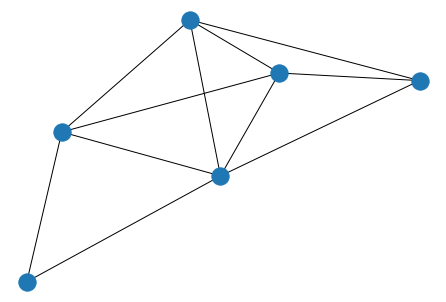

In [279]:
g = to_networkx(gp.d[0], to_undirected=True)
nx.draw(g)

In [280]:
len(gp.d)

92

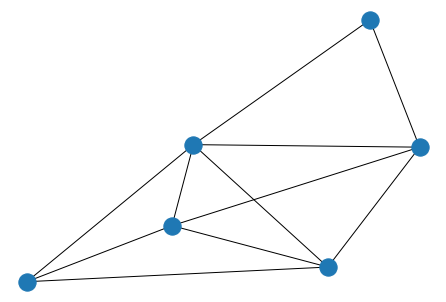

In [281]:
g = to_networkx(gp.d[0], to_undirected=True)
nx.draw(g)

In [282]:
len(gp.d)

92

In [283]:
len(gp.selection)

92

In [284]:
gp.selection[10]['PDB'].iloc[0]

'4UHR'

In [285]:
gp.d[0].x

tensor([ 5,  9, 14,  4,  9,  0])

In [286]:
len(gp.edges[0])

28

In [287]:
gp.d[0]

Data(edge_attr=[28, 2], edge_index=[2, 28], pos=[6, 3], x=[6], y=[4])

In [288]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

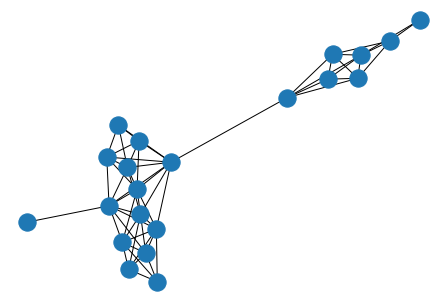

In [289]:
g = to_networkx(gp.d[10], to_undirected=True)
nx.draw(g)

In [290]:
gp.p.table

,uniprot(gene),receptor family,Cl.,Species,Method,PDB,Resolution,Preferred Chain,State,Degree active %,Family,Subtype,Function,Gs,Gi/o,Gq/11,G12/13
0,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,cryo-EM,6G79,3.8,S,Active,100,Gi/o,αo,Agonist,0.0,8.9,6.7,0.0
1,CNR2,Cannabinoid,A(Rhodopsin),Human,X-ray,5ZTY,2.8,A,Inactive,6,-,-,Antagonist,0.0,8.9,0.0,0.0
2,CXCR2,Chemokine,A(Rhodopsin),Human,cryo-EM,6LFO,3.4,R,Active,100,Gi/o,αi1,Agonist,0.0,9.5,0.0,0.0
3,CXCR2,Chemokine,A(Rhodopsin),Human,cryo-EM,6LFM,3.5,R,Active,100,Gi/o,αi1,Agonist,0.0,9.5,0.0,0.0
4,CXCR2,Chemokine,A(Rhodopsin),Human,X-ray,6LFL,3.2,A,Inactive,7,-,-,Allostericantagonist,0.0,9.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,GNRHR,Gonadotrophin-releasinghormone,A(Rhodopsin),Human,X-ray,7BR3,2.8,A,Inactive,24,-,-,Antagonist,0.0,8.9,9.4,0.0
352,GLP1R,Glucagon,B1(Secretin),Human,cryo-EM,7LCK,3.2,R,Active,100,-,-,Agonist,10.6,0.0,0.0,0.0
353,PE2R4,Prostanoid,A(Rhodopsin),Human,cryo-EM,7D7M,3.3,A,Active,100,Gs,αs,Agonist,10.4,8.9,8.7,7.4
354,5HT1B,5-Hydroxytryptamine,A(Rhodopsin),Human,X-ray,5V54,3.9,A,Inactive,24,-,-,Antagonist,0.0,8.9,6.7,0.0


In [291]:
gp.d[10]

Data(edge_attr=[139, 2], edge_index=[2, 139], pos=[21, 3], x=[21], y=[4])

In [292]:
len(gp.d)

92

In [386]:
gp.d[0].edge_index.numpy()[0]

array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 5, 5, 5, 5], dtype=int64)

In [433]:
list(gp.d[0].pos.numpy())

[array([17.962, 18.088,  2.537], dtype=float32),
 array([13.057, 19.473,  2.389], dtype=float32),
 array([13.834, 22.435,  4.67 ], dtype=float32),
 array([ 9.367, 22.825,  1.7  ], dtype=float32),
 array([ 8.793, 22.643,  5.482], dtype=float32),
 array([ 9.081, 26.437,  5.681], dtype=float32)]

In [334]:
label_dict = {v: k for k, v in RES_DICT.items()}
print(label_dict)

{0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


In [394]:
import igraph as ig

In [404]:
G=ig.Graph(gp.d[0].edge_index.numpy().T, directed=False)

In [406]:
layt=G.layout('kk', dim=3)

In [435]:
N = 6

In [436]:
Xn = [layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn = [layt[k][1] for k in range(N)]# y-coordinates
Zn = [layt[k][2] for k in range(N)]# z-coordinates

In [510]:
def get_edge_vecs(pos, edges):
    Xe=[]
    Ye=[]
    Ze=[]
    for e in edges:
        if e[0] != e[1]:
            Xe += [pos[e[0]][0], pos[e[1]][0], None]
            Ye += [pos[e[0]][1], pos[e[1]][1], None]
            Ze += [pos[e[0]][2], pos[e[1]][2], None]
    return Xe, Ye, Ze

In [511]:
gp.d[10].pos.numpy().shape

(21, 3)

In [512]:
gp.d[10].edge_index.numpy()

array([[ 0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
        10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
        16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
        18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20],
       [ 0,  7,  1,  2,  3,  4,  5,  1,  2,  3,  4,  5,  6,  1,  2,  3,
         4,  5,  6,  7,  1,  2,  3,  4,  5,  6,  7,  8,  1,  2,  3,  4,
         5,  6,  7,  8,  9,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  3,
         4,  5,  6,  7,  8,  9, 10, 11,  4,  5,  6,  7,  8,  9, 10, 11,
        12,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15,  6,  7,  8,  9, 10,
        11,

In [513]:
get_edge_vecs(gp.d[0].pos.numpy(), gp.d[0].edge_index.numpy().T)

([17.962,
  13.057,
  None,
  17.962,
  13.834,
  None,
  13.057,
  17.962,
  None,
  13.057,
  13.834,
  None,
  13.057,
  9.367,
  None,
  13.057,
  8.793,
  None,
  13.834,
  17.962,
  None,
  13.834,
  13.057,
  None,
  13.834,
  9.367,
  None,
  13.834,
  8.793,
  None,
  13.834,
  9.081,
  None,
  9.367,
  13.057,
  None,
  9.367,
  13.834,
  None,
  9.367,
  8.793,
  None,
  9.367,
  9.081,
  None,
  8.793,
  13.057,
  None,
  8.793,
  13.834,
  None,
  8.793,
  9.367,
  None,
  8.793,
  9.081,
  None,
  9.081,
  13.834,
  None,
  9.081,
  9.367,
  None,
  9.081,
  8.793,
  None],
 [18.088,
  19.473,
  None,
  18.088,
  22.435,
  None,
  19.473,
  18.088,
  None,
  19.473,
  22.435,
  None,
  19.473,
  22.825,
  None,
  19.473,
  22.643,
  None,
  22.435,
  18.088,
  None,
  22.435,
  19.473,
  None,
  22.435,
  22.825,
  None,
  22.435,
  22.643,
  None,
  22.435,
  26.437,
  None,
  22.825,
  19.473,
  None,
  22.825,
  22.435,
  None,
  22.825,
  22.643,
  None,
  22.825,
  2

In [525]:
def plot_graph(gp, idx, weights=None):
    data = gp.d[idx]
    selection = gp.selection[idx]
    points = data.pos.numpy()
    edges = data.edge_index.numpy().T
    Xe, Ye, Ze = get_edge_vecs(points, edges)
    if weights==None:
        weights=selection['generic_position'].astype(float)
        
    E = go.Scatter3d(
        x=Xe,
        y=Ye,
        z=Ze,
        mode='lines',
        line=dict(color='rgb(125,125,125)', width=3),
        hoverinfo='none',
        name='Edges',
        )
    
    P = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        text=selection['generic_position'].astype(float),
        hoverinfo='text',
        mode='markers',
        name=selection['PDB'].iloc[0],
        marker={
            'size': 7,
            'opacity': 0.8,
            'color': weights,
        }
    )
    
    
    
    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    data = [E, P]
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.update_traces(textposition='top center')
    plot_figure.show()    

In [526]:
gp.selection[10]['PDB'].iloc[0]

'4UHR'

In [530]:
plot_graph(gp, 0)

In [534]:
df = gp.p.dfl[gp.p.dfl_list.index('2YDV')]

In [535]:
df

,index,PDB,auth_asym_id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,identifier,label_comp_sid,generic_position
0,1,2YDV,A,CA,C,36.094,-0.818,-29.646,AA2AR_HUMAN,I,1.29
1,9,2YDV,A,CA,C,35.353,0.879,-33.020,AA2AR_HUMAN,M,1.30
2,17,2YDV,A,CA,C,32.622,3.022,-31.402,AA2AR_HUMAN,G,1.31
3,21,2YDV,A,CA,C,29.057,4.148,-32.116,AA2AR_HUMAN,S,1.32
4,27,2YDV,A,CA,C,28.404,7.126,-34.428,AA2AR_HUMAN,S,1.33
...,...,...,...,...,...,...,...,...,...,...,...
310,2407,2YDV,A,CA,C,10.271,41.062,-54.024,AA2AR_HUMAN,N,
311,2415,2YDV,A,CA,C,6.877,42.480,-53.006,AA2AR_HUMAN,L,
312,2423,2YDV,A,CA,C,7.789,46.011,-54.133,AA2AR_HUMAN,Y,
313,2435,2YDV,A,CA,C,8.352,45.003,-57.796,AA2AR_HUMAN,F,


In [536]:
df[df['generic_position']!='']

,index,PDB,auth_asym_id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,identifier,label_comp_sid,generic_position
0,1,2YDV,A,CA,C,36.094,-0.818,-29.646,AA2AR_HUMAN,I,1.29
1,9,2YDV,A,CA,C,35.353,0.879,-33.020,AA2AR_HUMAN,M,1.30
2,17,2YDV,A,CA,C,32.622,3.022,-31.402,AA2AR_HUMAN,G,1.31
3,21,2YDV,A,CA,C,29.057,4.148,-32.116,AA2AR_HUMAN,S,1.32
4,27,2YDV,A,CA,C,28.404,7.126,-34.428,AA2AR_HUMAN,S,1.33
...,...,...,...,...,...,...,...,...,...,...,...
299,2324,2YDV,A,CA,C,19.898,37.079,-38.868,AA2AR_HUMAN,Q,8.65
300,2333,2YDV,A,CA,C,16.572,37.262,-40.714,AA2AR_HUMAN,Q,8.66
301,2342,2YDV,A,CA,C,17.554,40.631,-42.252,AA2AR_HUMAN,E,8.67
302,2351,2YDV,A,CA,C,18.974,39.243,-45.550,AA2AR_HUMAN,P,8.68


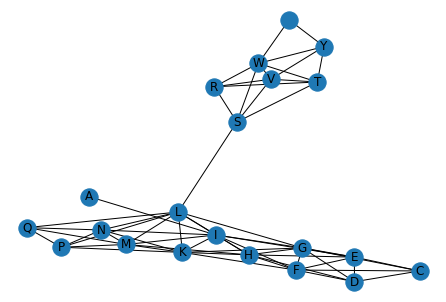

In [504]:
g = to_networkx(gp.d[10], to_undirected=True)
nx.draw(g, labels=label_dict, with_labels = True)

In [294]:
from torch_geometric.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [295]:
validation_split = .2
shuffle_dataset = True
random_seed = 42
batch_size  = 4

# Creating data indices for training and validation splits
dataset_size = len(gp)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(gp, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(gp, batch_size=batch_size, sampler=valid_sampler)

In [296]:
gp.__getitem__(0)

Data(edge_attr=[28, 2], edge_index=[2, 28], pos=[6, 3], x=[6], y=[4])

In [297]:
model_path = 'models/'

In [298]:
n_outputs=4
h5n = H5Net(n_outputs=n_outputs, aggr='add')

In [299]:
# h5n.to('cuda')

In [319]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(h5n.parameters(), lr=0.000001)
n_epochs = 1000


for e in range(n_epochs):
    print("EPOCH", e)
    training_loss = 0
    t_bar = tqdm(enumerate(train_loader), desc='TRAINING')
    for b,  batch in t_bar:
        batch.z = batch.x
        # batch.to('cuda')
        pred = h5n(batch)
        target = batch.y / 10  # very crude normalization! (should substract upper & lower limit etc)
        target = target.reshape(-1, n_outputs)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        training_loss = (training_loss * b + loss) / (b + 1)
        if b % 5 == 0:
            """print("target: {} <> prediction: {}".format(np.round_(target[0].cpu().detach().numpy(), 3), 
                                                        np.round_(pred[0].cpu().detach().numpy(), 3)))"""
            t_bar.set_description('TRAINING: mean epoch loss = '+str(round(float(training_loss), 6)))
    
    with torch.no_grad():
        validation_loss = 0
        t_bar = tqdm(enumerate(validation_loader), desc='VALIDATION')
        for b,  batch in t_bar:
            batch.z = batch.x
            #batch.to('cuda')
            pred = h5n(batch)
            target = batch.y / 12
            target = target.reshape(-1, n_outputs)
            loss = criterion(pred, target)
            validation_loss = (validation_loss * b + loss) / (b + 1)
            if b % 5 == 0:
                t_bar.set_description('VALIDATION: mean epoch loss = '+str(round(float(validation_loss), 6)))
            if b % 5 == 0:
                target_ = np.round_(target[0].cpu().detach().numpy() * 12, 2)
                pred_ = np.round_(pred[0].cpu().detach().numpy() * 12, 2)
                print("target: {} <> prediction: {}".format(target_, 
                                                            pred_))

TRAINING: mean epoch loss = 0.136418: : 5it [00:00, 40.61it/s]

EPOCH 0


TRAINING: mean epoch loss = 0.134123: : 19it [00:00, 40.26it/s]
VALIDATION: mean epoch loss = 0.088358: : 5it [00:00, 115.33it/s]
TRAINING: mean epoch loss = 0.103963: : 4it [00:00, 37.46it/s]

target: [10.8  0.   9.   0. ] <> prediction: [7.89 4.46 6.74 0.86]
EPOCH 1


TRAINING: mean epoch loss = 0.125119: : 19it [00:00, 40.70it/s]
VALIDATION: mean epoch loss = 0.053605: : 5it [00:00, 97.30it/s]
TRAINING: mean epoch loss = 0.153443: : 5it [00:00, 44.16it/s]

target: [0.  7.2 7.4 0. ] <> prediction: [7.87 4.46 6.71 0.88]
EPOCH 2


TRAINING: mean epoch loss = 0.137909: : 19it [00:00, 42.47it/s]
VALIDATION: mean epoch loss = 0.063881: : 5it [00:00, 87.78it/s]
TRAINING: mean epoch loss = 0.132991: : 5it [00:00, 47.70it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.87 4.46 6.75 0.86]
EPOCH 3


TRAINING: mean epoch loss = 0.128876: : 19it [00:00, 42.30it/s]
VALIDATION: mean epoch loss = 0.0789: : 5it [00:00, 97.76it/s]
TRAINING: mean epoch loss = 0.075259: : 4it [00:00, 33.83it/s]

target: [0.  7.2 7.4 0. ] <> prediction: [7.99 4.36 6.74 0.74]
EPOCH 4


TRAINING: mean epoch loss = 0.123464: : 19it [00:00, 37.83it/s]
VALIDATION: mean epoch loss = 0.060279: : 5it [00:00, 102.12it/s]
TRAINING: mean epoch loss = 0.126186: : 4it [00:00, 39.17it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [7.98 4.4  6.75 0.77]
EPOCH 5


TRAINING: mean epoch loss = 0.125101: : 19it [00:00, 40.17it/s]
VALIDATION: mean epoch loss = 0.085305: : 5it [00:00, 90.87it/s]
TRAINING: mean epoch loss = 0.117704: : 5it [00:00, 43.14it/s]

target: [5.9 0.  0.  0. ] <> prediction: [8.   4.36 6.77 0.75]
EPOCH 6


TRAINING: mean epoch loss = 0.134955: : 19it [00:00, 37.85it/s]
VALIDATION: mean epoch loss = 0.074826: : 5it [00:00, 69.55it/s]
TRAINING: mean epoch loss = 0.240227: : 3it [00:00, 28.52it/s]

target: [5.9 0.  0.  0. ] <> prediction: [8.03 4.36 6.78 0.73]
EPOCH 7


TRAINING: mean epoch loss = 0.129733: : 19it [00:00, 29.50it/s]
VALIDATION: mean epoch loss = 0.088086: : 5it [00:00, 70.39it/s]
TRAINING: mean epoch loss = 0.156294: : 3it [00:00, 29.79it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [7.94 4.38 6.74 0.78]
EPOCH 8


TRAINING: mean epoch loss = 0.136188: : 19it [00:00, 31.22it/s]
VALIDATION: mean epoch loss = 0.104811: : 5it [00:00, 81.17it/s]
TRAINING: mean epoch loss = 0.067435: : 4it [00:00, 32.01it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.92 4.42 6.78 0.78]
EPOCH 9


TRAINING: mean epoch loss = 0.127396: : 19it [00:00, 34.07it/s]
VALIDATION: mean epoch loss = 0.072231: : 5it [00:00, 81.40it/s]
TRAINING: mean epoch loss = 0.104599: : 3it [00:00, 29.74it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.96 4.37 6.77 0.75]
EPOCH 10


TRAINING: mean epoch loss = 0.135978: : 19it [00:00, 29.93it/s]
VALIDATION: mean epoch loss = 0.144481: : 5it [00:00, 67.85it/s]
TRAINING: mean epoch loss = 0.13165: : 3it [00:00, 25.11it/s]

target: [11.6  0.  10.4  0. ] <> prediction: [8.02 4.34 6.74 0.71]
EPOCH 11


TRAINING: mean epoch loss = 0.129225: : 19it [00:00, 29.61it/s]
VALIDATION: mean epoch loss = 0.071117: : 5it [00:00, 84.96it/s]
TRAINING: mean epoch loss = 0.161916: : 3it [00:00, 27.44it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [8.   4.33 6.79 0.68]
EPOCH 12


TRAINING: mean epoch loss = 0.127652: : 19it [00:00, 32.13it/s]
VALIDATION: mean epoch loss = 0.087602: : 5it [00:00, 77.47it/s]
TRAINING: mean epoch loss = 0.129658: : 4it [00:00, 34.56it/s]

target: [10.8  0.   9.   0. ] <> prediction: [8.04 4.32 6.76 0.68]
EPOCH 13


TRAINING: mean epoch loss = 0.126894: : 19it [00:00, 35.90it/s]
VALIDATION: mean epoch loss = 0.055346: : 5it [00:00, 77.63it/s]
TRAINING: mean epoch loss = 0.242916: : 0it [00:00, ?it/s]

target: [7.  0.  6.2 0. ] <> prediction: [8.1  4.29 6.74 0.63]
EPOCH 14


TRAINING: mean epoch loss = 0.129566: : 19it [00:00, 30.86it/s]
VALIDATION: mean epoch loss = 0.063331: : 5it [00:00, 78.88it/s]
TRAINING: mean epoch loss = 0.178545: : 0it [00:00, ?it/s]

target: [10.8  0.   9.   0. ] <> prediction: [8.07 4.3  6.76 0.65]
EPOCH 15


TRAINING: mean epoch loss = 0.133091: : 19it [00:00, 26.43it/s]
VALIDATION: mean epoch loss = 0.099311: : 5it [00:00, 69.10it/s]
TRAINING: mean epoch loss = 0.098046: : 4it [00:00, 33.67it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.12 4.3  6.79 0.62]
EPOCH 16


TRAINING: mean epoch loss = 0.136798: : 19it [00:00, 29.85it/s]
VALIDATION: mean epoch loss = 0.05175: : 5it [00:00, 77.15it/s]
TRAINING: mean epoch loss = 0.175681: : 0it [00:00, ?it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.96 4.36 6.75 0.69]
EPOCH 17


TRAINING: mean epoch loss = 0.129638: : 19it [00:00, 31.46it/s]
VALIDATION: mean epoch loss = 0.109692: : 5it [00:00, 75.89it/s]
TRAINING: mean epoch loss = 0.070503: : 0it [00:00, ?it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.12 4.28 6.73 0.62]
EPOCH 18


TRAINING: mean epoch loss = 0.133096: : 19it [00:00, 29.68it/s]
VALIDATION: mean epoch loss = 0.100143: : 5it [00:00, 84.50it/s]
TRAINING: mean epoch loss = 0.126312: : 3it [00:00, 27.39it/s]

target: [5.9 0.  0.  0. ] <> prediction: [8.11 4.27 6.72 0.61]
EPOCH 19


TRAINING: mean epoch loss = 0.122949: : 19it [00:00, 31.74it/s]
VALIDATION: mean epoch loss = 0.087233: : 5it [00:00, 79.76it/s]
TRAINING: mean epoch loss = 0.053846: : 4it [00:00, 31.36it/s]

target: [10.9  0.   0.   0. ] <> prediction: [8.09 4.3  6.71 0.62]
EPOCH 20


TRAINING: mean epoch loss = 0.134826: : 19it [00:00, 31.53it/s]
VALIDATION: mean epoch loss = 0.048726: : 5it [00:00, 80.64it/s]
TRAINING: mean epoch loss = 0.120061: : 3it [00:00, 29.39it/s]

target: [8.2 0.  7.  0. ] <> prediction: [8.04 4.31 6.69 0.62]
EPOCH 21


TRAINING: mean epoch loss = 0.129286: : 19it [00:00, 29.76it/s]
VALIDATION: mean epoch loss = 0.109346: : 5it [00:00, 63.35it/s]
TRAINING: mean epoch loss = 0.076984: : 3it [00:00, 25.83it/s]

target: [10.6  0.   0.   0. ] <> prediction: [8.1  4.28 6.69 0.59]
EPOCH 22


TRAINING: mean epoch loss = 0.136757: : 19it [00:00, 29.87it/s]
VALIDATION: mean epoch loss = 0.095821: : 5it [00:00, 74.43it/s]
TRAINING: mean epoch loss = 0.18351: : 3it [00:00, 28.76it/s]

target: [0.  7.2 7.4 0. ] <> prediction: [8.18 4.22 6.68 0.53]
EPOCH 23


TRAINING: mean epoch loss = 0.123275: : 19it [00:00, 30.75it/s]
VALIDATION: mean epoch loss = 0.092035: : 5it [00:00, 75.16it/s]
TRAINING: mean epoch loss = 0.069399: : 3it [00:00, 26.34it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [8.26 4.18 6.72 0.5 ]
EPOCH 24


TRAINING: mean epoch loss = 0.122685: : 19it [00:00, 30.21it/s]
VALIDATION: mean epoch loss = 0.127741: : 5it [00:00, 67.11it/s]
TRAINING: mean epoch loss = 0.12881: : 3it [00:00, 29.65it/s]

target: [10.6  0.   0.   0. ] <> prediction: [8.09 4.3  6.65 0.59]
EPOCH 25


TRAINING: mean epoch loss = 0.127494: : 19it [00:00, 27.77it/s]
VALIDATION: mean epoch loss = 0.13008: : 5it [00:00, 73.68it/s]
TRAINING: mean epoch loss = 0.204707: : 3it [00:00, 27.14it/s]

target: [10.9  0.   0.   0. ] <> prediction: [8.11 4.29 6.61 0.55]
EPOCH 26


TRAINING: mean epoch loss = 0.128296: : 19it [00:00, 30.34it/s]
VALIDATION: mean epoch loss = 0.079327: : 5it [00:00, 77.73it/s]
TRAINING: mean epoch loss = 0.128843: : 4it [00:00, 31.96it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [8.06 4.3  6.66 0.56]
EPOCH 27


TRAINING: mean epoch loss = 0.127476: : 19it [00:00, 32.88it/s]
VALIDATION: mean epoch loss = 0.081803: : 5it [00:00, 73.60it/s]
TRAINING: mean epoch loss = 0.210967: : 3it [00:00, 28.57it/s]

target: [10.6  0.   0.   0. ] <> prediction: [8.11 4.3  6.59 0.57]
EPOCH 28


TRAINING: mean epoch loss = 0.135701: : 19it [00:00, 33.61it/s]
VALIDATION: mean epoch loss = 0.099: : 5it [00:00, 76.53it/s]
TRAINING: mean epoch loss = 0.07335: : 4it [00:00, 35.33it/s]

target: [0.  8.9 0.  0. ] <> prediction: [8.13 4.24 6.62 0.51]
EPOCH 29


TRAINING: mean epoch loss = 0.136944: : 19it [00:00, 33.33it/s]
VALIDATION: mean epoch loss = 0.085527: : 5it [00:00, 80.61it/s]
TRAINING: mean epoch loss = 0.150564: : 4it [00:00, 31.26it/s]

target: [8.2 0.  7.  0. ] <> prediction: [8.13 4.27 6.64 0.51]
EPOCH 30


TRAINING: mean epoch loss = 0.121301: : 19it [00:00, 32.87it/s]
VALIDATION: mean epoch loss = 0.071269: : 5it [00:00, 75.91it/s]
TRAINING: mean epoch loss = 0.131326: : 3it [00:00, 26.85it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [8.02 4.28 6.65 0.52]
EPOCH 31


TRAINING: mean epoch loss = 0.130155: : 19it [00:00, 32.42it/s]
VALIDATION: mean epoch loss = 0.117721: : 5it [00:00, 72.75it/s]
TRAINING: mean epoch loss = 0.212575: : 4it [00:00, 37.73it/s]

target: [0.  7.7 0.  0. ] <> prediction: [8.14 4.26 6.58 0.5 ]
EPOCH 32


TRAINING: mean epoch loss = 0.128873: : 19it [00:00, 33.28it/s]
VALIDATION: mean epoch loss = 0.071472: : 5it [00:00, 83.67it/s]
TRAINING: mean epoch loss = 0.083306: : 4it [00:00, 33.47it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [8.01 4.34 6.53 0.56]
EPOCH 33


TRAINING: mean epoch loss = 0.132137: : 19it [00:00, 35.08it/s]
VALIDATION: mean epoch loss = 0.089829: : 5it [00:00, 95.46it/s]
TRAINING: mean epoch loss = 0.084053: : 4it [00:00, 32.74it/s]

target: [0.  8.9 0.  0. ] <> prediction: [8.14 4.23 6.59 0.45]
EPOCH 34


TRAINING: mean epoch loss = 0.135119: : 19it [00:00, 33.02it/s]
VALIDATION: mean epoch loss = 0.058587: : 5it [00:00, 74.76it/s]
TRAINING: mean epoch loss = 0.106748: : 3it [00:00, 27.05it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.18 4.22 6.6  0.45]
EPOCH 35


TRAINING: mean epoch loss = 0.129508: : 19it [00:00, 30.74it/s]
VALIDATION: mean epoch loss = 0.074497: : 5it [00:00, 85.67it/s]
TRAINING: mean epoch loss = 0.109091: : 4it [00:00, 33.21it/s]

target: [10.9  0.   0.   0. ] <> prediction: [8.15 4.27 6.54 0.48]
EPOCH 36


TRAINING: mean epoch loss = 0.137506: : 19it [00:00, 32.50it/s]
VALIDATION: mean epoch loss = 0.103176: : 5it [00:00, 77.59it/s]
TRAINING: mean epoch loss = 0.233569: : 0it [00:00, ?it/s]

target: [10.9  0.   0.   0. ] <> prediction: [8.19 4.22 6.5  0.43]
EPOCH 37


TRAINING: mean epoch loss = 0.137287: : 19it [00:00, 33.26it/s]
VALIDATION: mean epoch loss = 0.064457: : 5it [00:00, 85.00it/s]
TRAINING: mean epoch loss = 0.183749: : 3it [00:00, 26.72it/s]

target: [10.8  0.   9.   0. ] <> prediction: [8.13 4.3  6.5  0.46]
EPOCH 38


TRAINING: mean epoch loss = 0.124057: : 19it [00:00, 32.33it/s]
VALIDATION: mean epoch loss = 0.105799: : 5it [00:00, 92.78it/s]
TRAINING: mean epoch loss = 0.140162: : 3it [00:00, 28.71it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [8.06 4.24 6.54 0.44]
EPOCH 39


TRAINING: mean epoch loss = 0.127512: : 19it [00:00, 29.95it/s]
VALIDATION: mean epoch loss = 0.063072: : 5it [00:00, 72.80it/s]
TRAINING: mean epoch loss = 0.135872: : 3it [00:00, 27.46it/s]

target: [10.8  0.   9.   0. ] <> prediction: [8.14 4.25 6.49 0.43]
EPOCH 40


TRAINING: mean epoch loss = 0.131353: : 19it [00:00, 27.86it/s]
VALIDATION: mean epoch loss = 0.072303: : 5it [00:00, 60.67it/s]
TRAINING: mean epoch loss = 0.193566: : 3it [00:00, 27.47it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [7.95 4.35 6.49 0.5 ]
EPOCH 41


TRAINING: mean epoch loss = 0.123436: : 19it [00:00, 28.43it/s]
VALIDATION: mean epoch loss = 0.086801: : 5it [00:00, 69.81it/s]
TRAINING: mean epoch loss = 0.089487: : 3it [00:00, 26.85it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.14 4.29 6.49 0.42]
EPOCH 42


TRAINING: mean epoch loss = 0.125437: : 19it [00:00, 27.25it/s]
VALIDATION: mean epoch loss = 0.111367: : 5it [00:00, 74.96it/s]
TRAINING: mean epoch loss = 0.099324: : 3it [00:00, 28.99it/s]

target: [11.6  0.  10.4  0. ] <> prediction: [8.08 4.33 6.43 0.46]
EPOCH 43


TRAINING: mean epoch loss = 0.131461: : 19it [00:00, 33.26it/s]
VALIDATION: mean epoch loss = 0.100159: : 5it [00:00, 76.91it/s]
TRAINING: mean epoch loss = 0.173048: : 4it [00:00, 32.87it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [8.07 4.28 6.45 0.43]
EPOCH 44


TRAINING: mean epoch loss = 0.133921: : 19it [00:00, 33.66it/s]
VALIDATION: mean epoch loss = 0.09842: : 5it [00:00, 79.48it/s]
TRAINING: mean epoch loss = 0.16888: : 4it [00:00, 33.70it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [8.09 4.31 6.44 0.42]
EPOCH 45


TRAINING: mean epoch loss = 0.130025: : 19it [00:00, 30.93it/s]
VALIDATION: mean epoch loss = 0.104112: : 5it [00:00, 84.05it/s]
TRAINING: mean epoch loss = 0.10589: : 3it [00:00, 29.63it/s]

target: [0.  7.7 0.  0. ] <> prediction: [8.11 4.31 6.39 0.41]
EPOCH 46


TRAINING: mean epoch loss = 0.128543: : 19it [00:00, 31.84it/s]
VALIDATION: mean epoch loss = 0.031606: : 5it [00:00, 79.45it/s]
TRAINING: mean epoch loss = 0.218721: : 3it [00:00, 29.00it/s]

target: [7.  0.  6.2 0. ] <> prediction: [8.12 4.29 6.37 0.39]
EPOCH 47


TRAINING: mean epoch loss = 0.128215: : 19it [00:00, 31.71it/s]
VALIDATION: mean epoch loss = 0.049719: : 5it [00:00, 87.73it/s]
TRAINING: mean epoch loss = 0.140538: : 4it [00:00, 33.12it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [8.05 4.3  6.4  0.4 ]
EPOCH 48


TRAINING: mean epoch loss = 0.134002: : 19it [00:00, 32.50it/s]
VALIDATION: mean epoch loss = 0.083844: : 5it [00:00, 90.77it/s]
TRAINING: mean epoch loss = 0.101079: : 4it [00:00, 39.50it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [8.14 4.28 6.39 0.35]
EPOCH 49


TRAINING: mean epoch loss = 0.126614: : 19it [00:00, 33.72it/s]
VALIDATION: mean epoch loss = 0.08292: : 5it [00:00, 77.00it/s]
TRAINING: mean epoch loss = 0.130622: : 4it [00:00, 35.45it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.06 4.34 6.38 0.4 ]
EPOCH 50


TRAINING: mean epoch loss = 0.122462: : 19it [00:00, 32.44it/s]
VALIDATION: mean epoch loss = 0.108998: : 5it [00:00, 90.19it/s]
TRAINING: mean epoch loss = 0.120426: : 4it [00:00, 34.57it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [8.   4.29 6.32 0.38]
EPOCH 51


TRAINING: mean epoch loss = 0.126742: : 19it [00:00, 33.09it/s]
VALIDATION: mean epoch loss = 0.053466: : 5it [00:00, 77.26it/s]
TRAINING: mean epoch loss = 0.042442: : 4it [00:00, 32.92it/s]

target: [11.6  0.  10.4  0. ] <> prediction: [8.02 4.39 6.3  0.41]
EPOCH 52


TRAINING: mean epoch loss = 0.135241: : 19it [00:00, 34.05it/s]
VALIDATION: mean epoch loss = 0.063263: : 5it [00:00, 86.53it/s]
TRAINING: mean epoch loss = 0.131133: : 3it [00:00, 29.40it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.11 4.3  6.34 0.34]
EPOCH 53


TRAINING: mean epoch loss = 0.132029: : 19it [00:00, 31.61it/s]
VALIDATION: mean epoch loss = 0.121305: : 5it [00:00, 80.48it/s]
TRAINING: mean epoch loss = 0.13397: : 4it [00:00, 30.25it/s]

target: [10.9  0.   0.   0. ] <> prediction: [8.04 4.37 6.25 0.38]
EPOCH 54


TRAINING: mean epoch loss = 0.122749: : 19it [00:00, 31.57it/s]
VALIDATION: mean epoch loss = 0.11852: : 5it [00:00, 72.44it/s]
TRAINING: mean epoch loss = 0.092885: : 3it [00:00, 27.81it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [8.   4.33 6.28 0.36]
EPOCH 55


TRAINING: mean epoch loss = 0.133802: : 19it [00:00, 30.15it/s]
VALIDATION: mean epoch loss = 0.101927: : 5it [00:00, 87.29it/s]
TRAINING: mean epoch loss = 0.281966: : 4it [00:00, 32.97it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.99 4.37 6.27 0.37]
EPOCH 56


TRAINING: mean epoch loss = 0.139669: : 19it [00:00, 32.15it/s]
VALIDATION: mean epoch loss = 0.070647: : 5it [00:00, 79.97it/s]
TRAINING: mean epoch loss = 0.062617: : 4it [00:00, 30.69it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [8.04 4.32 6.3  0.33]
EPOCH 57


TRAINING: mean epoch loss = 0.128543: : 19it [00:00, 29.16it/s]
VALIDATION: mean epoch loss = 0.083394: : 5it [00:00, 76.76it/s]
TRAINING: mean epoch loss = 0.096317: : 3it [00:00, 28.77it/s]

target: [10.9  0.   0.   0. ] <> prediction: [8.   4.38 6.25 0.36]
EPOCH 58


TRAINING: mean epoch loss = 0.132149: : 19it [00:00, 25.16it/s]
VALIDATION: mean epoch loss = 0.106199: : 5it [00:00, 82.69it/s]
TRAINING: mean epoch loss = 0.116686: : 3it [00:00, 26.15it/s]

target: [11.6  0.  10.4  0. ] <> prediction: [8.   4.38 6.24 0.34]
EPOCH 59


TRAINING: mean epoch loss = 0.130981: : 19it [00:00, 29.74it/s]
VALIDATION: mean epoch loss = 0.149841: : 5it [00:00, 74.54it/s]
TRAINING: mean epoch loss = 0.166196: : 3it [00:00, 29.00it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.99 4.44 6.24 0.35]
EPOCH 60


TRAINING: mean epoch loss = 0.133975: : 19it [00:00, 28.64it/s]
VALIDATION: mean epoch loss = 0.100458: : 5it [00:00, 84.01it/s]
TRAINING: mean epoch loss = 0.124678: : 3it [00:00, 25.50it/s]

target: [0.  8.9 0.  0. ] <> prediction: [7.88 4.43 6.22 0.37]
EPOCH 61


TRAINING: mean epoch loss = 0.133622: : 19it [00:00, 30.12it/s]
VALIDATION: mean epoch loss = 0.067349: : 5it [00:00, 83.71it/s]
TRAINING: mean epoch loss = 0.080049: : 3it [00:00, 29.21it/s]

target: [11.6  0.  10.4  0. ] <> prediction: [7.99 4.38 6.25 0.31]
EPOCH 62


TRAINING: mean epoch loss = 0.13345: : 19it [00:00, 29.76it/s] 
VALIDATION: mean epoch loss = 0.081313: : 5it [00:00, 80.40it/s]
TRAINING: mean epoch loss = 0.198617: : 3it [00:00, 29.09it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.91 4.43 6.18 0.34]
EPOCH 63


TRAINING: mean epoch loss = 0.12793: : 19it [00:00, 30.02it/s] 
VALIDATION: mean epoch loss = 0.075262: : 5it [00:00, 69.52it/s]
TRAINING: mean epoch loss = 0.084588: : 4it [00:00, 32.06it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.84 4.46 6.2  0.35]
EPOCH 64


TRAINING: mean epoch loss = 0.131684: : 19it [00:00, 32.26it/s]
VALIDATION: mean epoch loss = 0.140391: : 5it [00:00, 74.09it/s]
TRAINING: mean epoch loss = 0.131962: : 3it [00:00, 29.83it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [7.81 4.47 6.16 0.36]
EPOCH 65


TRAINING: mean epoch loss = 0.140533: : 19it [00:00, 30.90it/s]
VALIDATION: mean epoch loss = 0.098099: : 5it [00:00, 76.30it/s]
TRAINING: mean epoch loss = 0.315164: : 3it [00:00, 29.36it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [7.93 4.43 6.2  0.29]
EPOCH 66


TRAINING: mean epoch loss = 0.138364: : 19it [00:00, 30.83it/s]
VALIDATION: mean epoch loss = 0.070121: : 5it [00:00, 69.17it/s]
TRAINING: mean epoch loss = 0.16803: : 3it [00:00, 29.71it/s]

target: [11.6  0.  10.4  0. ] <> prediction: [7.86 4.48 6.16 0.33]
EPOCH 67


TRAINING: mean epoch loss = 0.130318: : 19it [00:00, 31.72it/s]
VALIDATION: mean epoch loss = 0.101779: : 5it [00:00, 70.71it/s]
TRAINING: mean epoch loss = 0.046772: : 4it [00:00, 34.28it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.9  4.4  6.2  0.28]
EPOCH 68


TRAINING: mean epoch loss = 0.131638: : 19it [00:00, 31.75it/s]
VALIDATION: mean epoch loss = 0.110626: : 5it [00:00, 89.53it/s]
TRAINING: mean epoch loss = 0.111431: : 4it [00:00, 33.98it/s]

target: [0.  8.9 0.  0. ] <> prediction: [7.79 4.52 6.17 0.33]
EPOCH 69


TRAINING: mean epoch loss = 0.130762: : 19it [00:00, 33.86it/s]
VALIDATION: mean epoch loss = 0.085277: : 5it [00:00, 77.92it/s]
TRAINING: mean epoch loss = 0.097381: : 4it [00:00, 36.88it/s]

target: [10.8  0.   9.   0. ] <> prediction: [7.83 4.52 6.16 0.31]
EPOCH 70


TRAINING: mean epoch loss = 0.130234: : 19it [00:00, 34.54it/s]
VALIDATION: mean epoch loss = 0.13064: : 5it [00:00, 61.45it/s]
TRAINING: mean epoch loss = 0.288044: : 0it [00:00, ?it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [7.74 4.54 6.16 0.33]
EPOCH 71


TRAINING: mean epoch loss = 0.136967: : 19it [00:00, 31.90it/s]
VALIDATION: mean epoch loss = 0.073884: : 5it [00:00, 80.39it/s]
TRAINING: mean epoch loss = 0.105233: : 4it [00:00, 32.07it/s]

target: [10.8  0.   9.   0. ] <> prediction: [7.78 4.52 6.15 0.31]
EPOCH 72


TRAINING: mean epoch loss = 0.129853: : 19it [00:00, 30.48it/s]
VALIDATION: mean epoch loss = 0.07741: : 5it [00:00, 68.17it/s]
TRAINING: mean epoch loss = 0.064076: : 0it [00:00, ?it/s]

target: [0.  7.2 7.4 0. ] <> prediction: [7.72 4.59 6.08 0.34]
EPOCH 73


TRAINING: mean epoch loss = 0.128889: : 19it [00:00, 31.31it/s]
VALIDATION: mean epoch loss = 0.116767: : 5it [00:00, 77.01it/s]
TRAINING: mean epoch loss = 0.100086: : 4it [00:00, 31.03it/s]

target: [0.  7.7 0.  0. ] <> prediction: [7.71 4.59 6.09 0.33]
EPOCH 74


TRAINING: mean epoch loss = 0.133264: : 19it [00:00, 29.65it/s]
VALIDATION: mean epoch loss = 0.118672: : 5it [00:00, 68.63it/s]
TRAINING: mean epoch loss = 0.164672: : 3it [00:00, 23.16it/s]

target: [5.9 0.  0.  0. ] <> prediction: [7.7  4.6  6.08 0.32]
EPOCH 75


TRAINING: mean epoch loss = 0.136732: : 19it [00:00, 28.80it/s]
VALIDATION: mean epoch loss = 0.049963: : 5it [00:00, 67.07it/s]
TRAINING: mean epoch loss = 0.194101: : 0it [00:00, ?it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.74 4.55 6.07 0.28]
EPOCH 76


TRAINING: mean epoch loss = 0.132435: : 19it [00:00, 30.74it/s]
VALIDATION: mean epoch loss = 0.068846: : 5it [00:00, 80.69it/s]
TRAINING: mean epoch loss = 0.244387: : 0it [00:00, ?it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [7.58 4.64 6.12 0.35]
EPOCH 77


TRAINING: mean epoch loss = 0.136617: : 19it [00:00, 31.42it/s]
VALIDATION: mean epoch loss = 0.105741: : 5it [00:00, 88.18it/s]
TRAINING: mean epoch loss = 0.126324: : 4it [00:00, 33.03it/s]

target: [10.6  0.   0.   0. ] <> prediction: [7.68 4.61 6.1  0.31]
EPOCH 78


TRAINING: mean epoch loss = 0.126671: : 19it [00:00, 30.65it/s]
VALIDATION: mean epoch loss = 0.083161: : 5it [00:00, 78.57it/s]
TRAINING: mean epoch loss = 0.169034: : 3it [00:00, 29.47it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.66 4.6  6.11 0.29]
EPOCH 79


TRAINING: mean epoch loss = 0.119286: : 19it [00:00, 30.04it/s]
VALIDATION: mean epoch loss = 0.085211: : 5it [00:00, 67.91it/s]
TRAINING: mean epoch loss = 0.068852: : 0it [00:00, ?it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [7.51 4.69 6.07 0.36]
EPOCH 80


TRAINING: mean epoch loss = 0.136161: : 19it [00:00, 29.40it/s]
VALIDATION: mean epoch loss = 0.075327: : 5it [00:00, 75.96it/s]
TRAINING: mean epoch loss = 0.156284: : 3it [00:00, 26.67it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.6  4.66 6.1  0.3 ]
EPOCH 81


TRAINING: mean epoch loss = 0.125999: : 19it [00:00, 31.95it/s]
VALIDATION: mean epoch loss = 0.133353: : 5it [00:00, 87.03it/s]
TRAINING: mean epoch loss = 0.156106: : 4it [00:00, 34.88it/s]

target: [0.  7.7 0.  0. ] <> prediction: [7.59 4.64 6.08 0.29]
EPOCH 82


TRAINING: mean epoch loss = 0.129588: : 19it [00:00, 33.30it/s]
VALIDATION: mean epoch loss = 0.072679: : 5it [00:00, 73.35it/s]
TRAINING: mean epoch loss = 0.1798: : 3it [00:00, 28.27it/s]

target: [10.6  0.   0.   0. ] <> prediction: [7.65 4.63 6.08 0.27]
EPOCH 83


TRAINING: mean epoch loss = 0.136976: : 19it [00:00, 32.74it/s]
VALIDATION: mean epoch loss = 0.098655: : 5it [00:00, 82.06it/s]
TRAINING: mean epoch loss = 0.082945: : 3it [00:00, 29.76it/s]

target: [0.  8.9 0.  0. ] <> prediction: [7.54 4.67 6.1  0.29]
EPOCH 84


TRAINING: mean epoch loss = 0.124855: : 19it [00:00, 32.20it/s]
VALIDATION: mean epoch loss = 0.054946: : 5it [00:00, 76.37it/s]
TRAINING: mean epoch loss = 0.107093: : 3it [00:00, 29.80it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [7.57 4.67 6.13 0.27]
EPOCH 85


TRAINING: mean epoch loss = 0.126281: : 19it [00:00, 31.56it/s]
VALIDATION: mean epoch loss = 0.044395: : 5it [00:00, 86.34it/s]
TRAINING: mean epoch loss = 0.117882: : 3it [00:00, 29.95it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.53 4.71 6.07 0.29]
EPOCH 86


TRAINING: mean epoch loss = 0.13783: : 19it [00:00, 34.35it/s] 
VALIDATION: mean epoch loss = 0.050885: : 5it [00:00, 91.94it/s]
TRAINING: mean epoch loss = 0.199413: : 4it [00:00, 35.96it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.48 4.73 6.16 0.31]
EPOCH 87


TRAINING: mean epoch loss = 0.132589: : 19it [00:00, 34.19it/s]
VALIDATION: mean epoch loss = 0.087309: : 5it [00:00, 76.63it/s]
TRAINING: mean epoch loss = 0.089591: : 4it [00:00, 34.58it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.51 4.7  6.06 0.27]
EPOCH 88


TRAINING: mean epoch loss = 0.131778: : 19it [00:00, 33.49it/s]
VALIDATION: mean epoch loss = 0.100978: : 5it [00:00, 74.60it/s]
TRAINING: mean epoch loss = 0.076357: : 4it [00:00, 30.93it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [7.43 4.75 6.1  0.3 ]
EPOCH 89


TRAINING: mean epoch loss = 0.124982: : 19it [00:00, 32.34it/s]
VALIDATION: mean epoch loss = 0.095963: : 5it [00:00, 73.62it/s]
TRAINING: mean epoch loss = 0.183792: : 3it [00:00, 29.42it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [7.52 4.75 6.15 0.28]
EPOCH 90


TRAINING: mean epoch loss = 0.12723: : 19it [00:00, 32.58it/s] 
VALIDATION: mean epoch loss = 0.095229: : 5it [00:00, 77.54it/s]
TRAINING: mean epoch loss = 0.071623: : 3it [00:00, 29.20it/s]

target: [0.  7.7 0.  0. ] <> prediction: [7.44 4.75 6.09 0.28]
EPOCH 91


TRAINING: mean epoch loss = 0.130791: : 19it [00:00, 31.15it/s]
VALIDATION: mean epoch loss = 0.097535: : 5it [00:00, 80.99it/s]
TRAINING: mean epoch loss = 0.081113: : 4it [00:00, 34.42it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [7.34 4.74 6.15 0.28]
EPOCH 92


TRAINING: mean epoch loss = 0.135258: : 19it [00:00, 33.74it/s]
VALIDATION: mean epoch loss = 0.11648: : 5it [00:00, 80.37it/s]
TRAINING: mean epoch loss = 0.149313: : 0it [00:00, ?it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.35 4.84 6.09 0.32]
EPOCH 93


TRAINING: mean epoch loss = 0.128659: : 19it [00:00, 33.45it/s]
VALIDATION: mean epoch loss = 0.107055: : 5it [00:00, 75.87it/s]
TRAINING: mean epoch loss = 0.080166: : 4it [00:00, 33.54it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.36 4.81 6.12 0.3 ]
EPOCH 94


TRAINING: mean epoch loss = 0.129115: : 19it [00:00, 31.14it/s]
VALIDATION: mean epoch loss = 0.064848: : 5it [00:00, 85.59it/s]
TRAINING: mean epoch loss = 0.122852: : 4it [00:00, 36.66it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.37 4.77 6.12 0.27]
EPOCH 95


TRAINING: mean epoch loss = 0.132491: : 19it [00:00, 33.19it/s]
VALIDATION: mean epoch loss = 0.050941: : 5it [00:00, 87.94it/s]
TRAINING: mean epoch loss = 0.132338: : 4it [00:00, 33.05it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [7.39 4.84 6.14 0.27]
EPOCH 96


TRAINING: mean epoch loss = 0.131184: : 19it [00:00, 34.35it/s]
VALIDATION: mean epoch loss = 0.114409: : 5it [00:00, 76.35it/s]
TRAINING: mean epoch loss = 0.099105: : 4it [00:00, 34.12it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.38 4.79 6.11 0.27]
EPOCH 97


TRAINING: mean epoch loss = 0.128049: : 19it [00:00, 29.14it/s]
VALIDATION: mean epoch loss = 0.053504: : 5it [00:00, 71.08it/s]
TRAINING: mean epoch loss = 0.229313: : 0it [00:00, ?it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.33 4.9  6.09 0.3 ]
EPOCH 98


TRAINING: mean epoch loss = 0.132679: : 19it [00:00, 28.98it/s]
VALIDATION: mean epoch loss = 0.115964: : 5it [00:00, 66.13it/s]
TRAINING: mean epoch loss = 0.126747: : 0it [00:00, ?it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [7.22 4.89 6.12 0.32]
EPOCH 99


TRAINING: mean epoch loss = 0.124066: : 19it [00:00, 29.31it/s]
VALIDATION: mean epoch loss = 0.07582: : 5it [00:00, 71.61it/s]
TRAINING: mean epoch loss = 0.06746: : 0it [00:00, ?it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [7.39 4.71 6.24 0.2 ]
EPOCH 100


TRAINING: mean epoch loss = 0.118594: : 19it [00:00, 29.72it/s]
VALIDATION: mean epoch loss = 0.05279: : 5it [00:00, 60.95it/s]
TRAINING: mean epoch loss = 0.211497: : 0it [00:00, ?it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.25 4.84 6.16 0.27]
EPOCH 101


TRAINING: mean epoch loss = 0.134746: : 19it [00:00, 29.42it/s]
VALIDATION: mean epoch loss = 0.098358: : 5it [00:00, 82.31it/s]
TRAINING: mean epoch loss = 0.079362: : 0it [00:00, ?it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [7.24 4.81 6.15 0.25]
EPOCH 102


TRAINING: mean epoch loss = 0.136048: : 19it [00:00, 27.48it/s]
VALIDATION: mean epoch loss = 0.08613: : 5it [00:00, 79.58it/s]
TRAINING: mean epoch loss = 0.146482: : 4it [00:00, 32.61it/s]

target: [0.  7.7 0.  0. ] <> prediction: [7.23 4.9  6.12 0.28]
EPOCH 103


TRAINING: mean epoch loss = 0.126432: : 19it [00:00, 30.64it/s]
VALIDATION: mean epoch loss = 0.058418: : 5it [00:00, 87.40it/s]
TRAINING: mean epoch loss = 0.148994: : 4it [00:00, 36.12it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [7.18 4.95 6.12 0.32]
EPOCH 104


TRAINING: mean epoch loss = 0.131799: : 19it [00:00, 32.89it/s]
VALIDATION: mean epoch loss = 0.03922: : 5it [00:00, 87.83it/s]
TRAINING: mean epoch loss = 0.070854: : 4it [00:00, 30.85it/s]

target: [10.8  0.   9.   0. ] <> prediction: [7.28 4.81 6.2  0.22]
EPOCH 105


TRAINING: mean epoch loss = 0.124944: : 19it [00:00, 32.87it/s]
VALIDATION: mean epoch loss = 0.132947: : 5it [00:00, 79.13it/s]
TRAINING: mean epoch loss = 0.148139: : 3it [00:00, 29.49it/s]

target: [10.6  0.   0.   0. ] <> prediction: [7.25 4.84 6.17 0.24]
EPOCH 106


TRAINING: mean epoch loss = 0.134104: : 19it [00:00, 31.15it/s]
VALIDATION: mean epoch loss = 0.139707: : 5it [00:00, 82.15it/s]
TRAINING: mean epoch loss = 0.108597: : 4it [00:00, 30.90it/s]

target: [0.  8.9 6.7 0. ] <> prediction: [7.12 4.93 6.18 0.3 ]
EPOCH 107


TRAINING: mean epoch loss = 0.129616: : 19it [00:00, 33.43it/s]
VALIDATION: mean epoch loss = 0.084477: : 5it [00:00, 90.87it/s]
TRAINING: mean epoch loss = 0.155195: : 4it [00:00, 35.61it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.2  4.87 6.14 0.25]
EPOCH 108


TRAINING: mean epoch loss = 0.13297: : 19it [00:00, 34.54it/s] 
VALIDATION: mean epoch loss = 0.072231: : 5it [00:00, 81.85it/s]
TRAINING: mean epoch loss = 0.073088: : 3it [00:00, 26.92it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.16 4.9  6.22 0.26]
EPOCH 109


TRAINING: mean epoch loss = 0.122043: : 19it [00:00, 32.71it/s]
VALIDATION: mean epoch loss = 0.077846: : 5it [00:00, 86.62it/s]
TRAINING: mean epoch loss = 0.108101: : 4it [00:00, 34.11it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.16 4.84 6.25 0.23]
EPOCH 110


TRAINING: mean epoch loss = 0.130844: : 19it [00:00, 33.48it/s]
VALIDATION: mean epoch loss = 0.106868: : 5it [00:00, 83.37it/s]
TRAINING: mean epoch loss = 0.279091: : 4it [00:00, 37.96it/s]

target: [0.  7.7 0.  0. ] <> prediction: [7.08 4.92 6.21 0.27]
EPOCH 111


TRAINING: mean epoch loss = 0.139386: : 19it [00:00, 34.25it/s]
VALIDATION: mean epoch loss = 0.071523: : 5it [00:00, 83.70it/s]
TRAINING: mean epoch loss = 0.138813: : 4it [00:00, 32.60it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.09 4.96 6.22 0.29]
EPOCH 112


TRAINING: mean epoch loss = 0.132267: : 19it [00:00, 34.37it/s]
VALIDATION: mean epoch loss = 0.110072: : 5it [00:00, 85.69it/s]
TRAINING: mean epoch loss = 0.176658: : 0it [00:00, ?it/s]

target: [0.  8.9 0.  0. ] <> prediction: [7.1  4.94 6.22 0.27]
EPOCH 113


TRAINING: mean epoch loss = 0.122328: : 19it [00:00, 31.72it/s]
VALIDATION: mean epoch loss = 0.134224: : 5it [00:00, 90.40it/s]
TRAINING: mean epoch loss = 0.089105: : 3it [00:00, 28.04it/s]

target: [0.  8.9 0.  0. ] <> prediction: [7.14 4.86 6.23 0.22]
EPOCH 114


TRAINING: mean epoch loss = 0.134392: : 19it [00:00, 28.24it/s]
VALIDATION: mean epoch loss = 0.113618: : 5it [00:00, 71.83it/s]
TRAINING: mean epoch loss = 0.080037: : 0it [00:00, ?it/s]

target: [0.  7.2 7.4 0. ] <> prediction: [7.16 4.92 6.21 0.24]
EPOCH 115


TRAINING: mean epoch loss = 0.130649: : 19it [00:00, 31.07it/s]
VALIDATION: mean epoch loss = 0.067322: : 5it [00:00, 80.49it/s]
TRAINING: mean epoch loss = 0.069847: : 0it [00:00, ?it/s]

target: [5.  8.4 7.4 0. ] <> prediction: [7.03 5.01 6.24 0.31]
EPOCH 116


TRAINING: mean epoch loss = 0.124117: : 19it [00:00, 30.67it/s]
VALIDATION: mean epoch loss = 0.074936: : 5it [00:00, 76.93it/s]
TRAINING: mean epoch loss = 0.100123: : 3it [00:00, 28.98it/s]

target: [8.2 0.  7.  0. ] <> prediction: [7.07 4.89 6.28 0.23]
EPOCH 117


TRAINING: mean epoch loss = 0.13337: : 19it [00:00, 28.97it/s] 
VALIDATION: mean epoch loss = 0.112521: : 5it [00:00, 79.74it/s]
TRAINING: mean epoch loss = 0.130593: : 3it [00:00, 27.96it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [7.13 4.89 6.29 0.21]
EPOCH 118


TRAINING: mean epoch loss = 0.126105: : 19it [00:00, 30.72it/s]
VALIDATION: mean epoch loss = 0.049491: : 5it [00:00, 71.06it/s]
TRAINING: mean epoch loss = 0.168477: : 3it [00:00, 29.67it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.09 4.9  6.28 0.23]
EPOCH 119


TRAINING: mean epoch loss = 0.130846: : 19it [00:00, 29.43it/s]
VALIDATION: mean epoch loss = 0.09854: : 5it [00:00, 70.12it/s]
TRAINING: mean epoch loss = 0.093569: : 3it [00:00, 26.87it/s]

target: [5.7 0.  5.6 0. ] <> prediction: [6.93 4.98 6.32 0.29]
EPOCH 120


TRAINING: mean epoch loss = 0.136168: : 19it [00:00, 28.38it/s]
VALIDATION: mean epoch loss = 0.067004: : 5it [00:00, 77.67it/s]
TRAINING: mean epoch loss = 0.084873: : 3it [00:00, 26.63it/s]

target: [8.5 5.7 7.4 0. ] <> prediction: [7.04 4.92 6.33 0.23]
EPOCH 121


TRAINING: mean epoch loss = 0.129122: : 19it [00:00, 29.65it/s]
VALIDATION: mean epoch loss = 0.138047: : 5it [00:00, 72.63it/s]
TRAINING: mean epoch loss = 0.089847: : 3it [00:00, 28.47it/s]

target: [10.9  0.   0.   0. ] <> prediction: [7.04 5.01 6.34 0.28]
EPOCH 122


TRAINING: mean epoch loss = 0.135881: : 19it [00:00, 27.93it/s]
VALIDATION: mean epoch loss = 0.086918: : 5it [00:00, 71.48it/s]
TRAINING: mean epoch loss = 0.198685: : 3it [00:00, 27.78it/s]

target: [0.  7.2 7.4 0. ] <> prediction: [7.08 4.89 6.29 0.21]
EPOCH 123


TRAINING: mean epoch loss = 0.128261: : 19it [00:00, 29.58it/s]
VALIDATION: mean epoch loss = 0.034368: : 5it [00:00, 78.26it/s]
TRAINING: mean epoch loss = 0.135137: : 3it [00:00, 27.46it/s]

target: [8.3 0.  8.4 0. ] <> prediction: [7.02 4.95 6.33 0.24]
EPOCH 124


TRAINING: mean epoch loss = 0.122423: : 19it [00:00, 29.29it/s]
VALIDATION: mean epoch loss = 0.092098: : 5it [00:00, 77.35it/s]
TRAINING: mean epoch loss = 0.097156: : 4it [00:00, 31.87it/s]

target: [10.6  0.   0.   0. ] <> prediction: [7.   4.97 6.34 0.25]
EPOCH 125


TRAINING: mean epoch loss = 0.093305: : 7it [00:00, 25.67it/s]


KeyboardInterrupt: 

In [320]:
def analyse_single_residue_variation(model, sample):
    aas = [x for x in range(20)]
    with torch.no_grad():
        sample.z = sample.x
        residues = [int(x) for x in list(sample.x)]
        columns = [[str(x)+'_gs', str(x)+'_gi/o', str(x)+'_gq/11', str(x)+'_g12/13'] for x in residues]
        cols = [item for sublist in columns for item in sublist]
        df = pd.DataFrame(columns=cols, index=aas)
        affinities = list(model(sample)[0].numpy()*12)
        print(residues)
        for r, res in enumerate(residues):
            for i, aa in enumerate(aas):
                if res == aa:
                    for a, aff in enumerate(affinities):
                        df.at[aa, cols[r*4+a]] = aff
                else:
                    sample_ = sample
                    sample_.z[r] = aa
                    affinities_ = list(model(sample_)[0].numpy()*12)
                    for a, aff in enumerate(affinities_):
                        df.at[aa, cols[r*4+a]] = aff
    return df

In [321]:
batch_size  = 1

# Creating data indices for training and validation splits
dataset_size = len(gp)

analyse_loader = DataLoader(gp, batch_size=batch_size, shuffle=True)

In [322]:
sample = next(iter(analyse_loader))

In [323]:
df = analyse_single_residue_variation(h5n, sample)

[11, 17, 9, 17, 1, 18, 0, 17, 18, 9, 13, 11, 17, 16, 11, 19, 4, 17, 17, 15, 9, 0, 0, 0, 11, 7, 15, 15, 9, 0, 7, 2, 5, 0, 8, 7, 12, 4, 19, 0]


In [324]:
len([17, 17, 9, 16, 17, 5, 11, 9, 19, 7, 17, 15, 9, 15, 17, 15, 15, 17, 4, 7, 9, 1, 7, 2, 14, 7, 7, 11, 12, 9, 7, 19, 12, 9, 1, 11, 3])

37

In [325]:
gs_cols = [x for x in list(df.columns) if 's' in x]

In [328]:
df.T.std(axis=1).max()

0.03853908775188973

In [330]:
df.iloc[:, [125]]

,2_gi/o
0,5.010034
1,5.053737
2,4.929415
3,4.958961
4,4.976821
5,4.984027
6,5.004538
7,4.902027
8,4.998849
9,4.967833


In [329]:
for _, i in enumerate(df.T.std(axis=1)==0.03853908775188973):
    if i:
        print(i, _)

True 125


In [240]:
RES_DICT

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19}